#Overview

This Jupyter Notebook is crafted to analyze the historical Water Equivalent Thickness (WET) data for the Save Basin in Zimbabwe, sourced from grace.jpl.nasa.gov, covering the period from April 2002 to January 2023. Our analysis approach employ Python's pandas and matplotlib libraries to visualize the time series of Water Equivalent Thickness – Land by GRACE, GRACE-FO JPL over the specified years.

Throughout the analysis, we will integrate Machine Learning techniques, specifically Deep Learning and Neural Networks, to train that model for comprehensive examination and prediction of WET patterns.

## We begin by importing the necessary Python packages for data manipulation, visualization and our machine learning predictions


Now Lets import our packages



In [18]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

## Read the CSV file into a Pandas DataFrame

Next, we read the rainfall data from the CSV file into a Pandas DataFrame. The 'DateTime' column is parsed as dates for time-based analysis:

In [105]:
file_path = '/content/Blue_Pale_Dot_Visualization_Challenge/timeSeries.water_equivalent_thickness_–_land_(grace,_grace-fo_jpl).200204-202301.0_0_0_0 (2).csv'
df = pd.read_csv(file_path, parse_dates=['DateTime'])

## Plotting the Time Series

Now, let's visualize the time series of rainfall intensity using matplotlib. We'll create a line plot to show the variation in rainfall over the years:

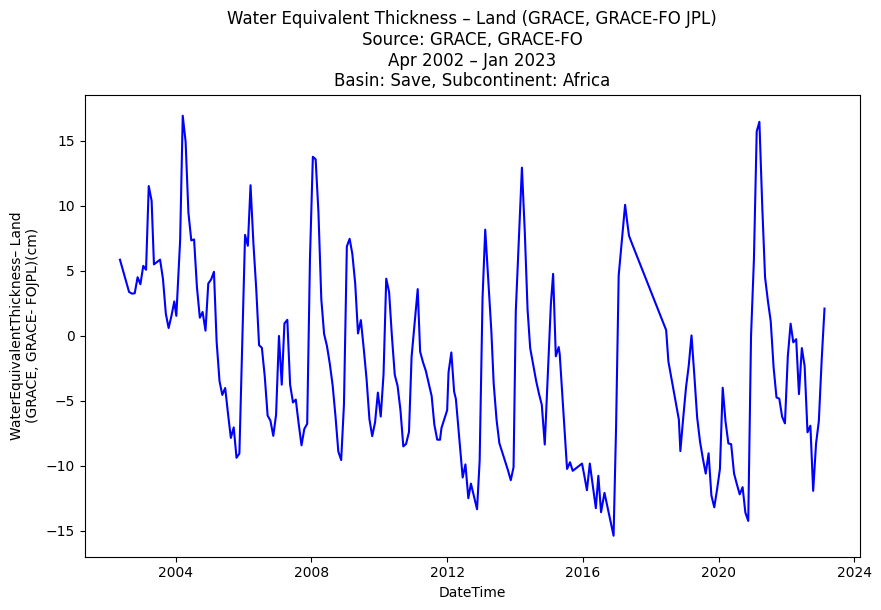

In [106]:
plt.figure(figsize=(10, 6))
plt.plot(df['DateTime'], df['Water Equivalent Thickness – Land (GRACE, GRACE-FO JPL)'], label='Polynomial Fit', color='blue')
plt.title('Water Equivalent Thickness – Land (GRACE, GRACE-FO JPL)\nSource: GRACE, GRACE-FO\nApr 2002 – Jan 2023\nBasin: Save, Subcontinent: Africa')
plt.xlabel('DateTime')
plt.ylabel('WaterEquivalentThickness– Land\n(GRACE, GRACE- FOJPL)(cm)')
plt.show()

This plot provides an overview of the Water Equivalent Thickness patterns in the Save River, offering insights into seasonal variations and trends over the specified time period.

# From the above visualization we add a Moving Average to get an intuition of how those indicators could be helpful to to forcast future water equivalent thickness.

By smoothing the data with a running mean can be useful for forecasting future values, especially when dealing with time series data. It provides a clearer picture of the overall trend, making it easier to make predictions by just looking at the visualization.

## Running mean


In [111]:
window_size = 6
running_mean = df['Water Equivalent Thickness – Land (GRACE, GRACE-FO JPL)'].rolling(window=window_size).mean()


## Plotting


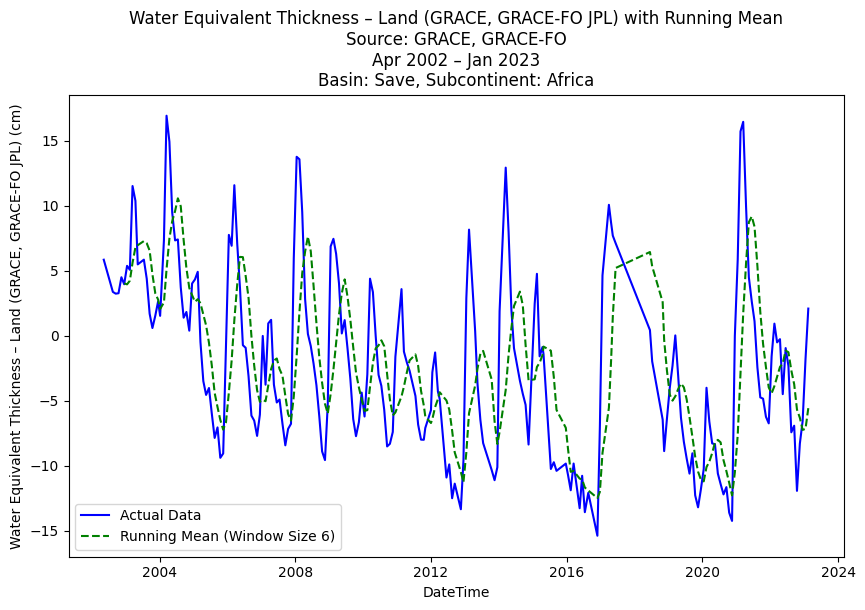

In [112]:
plt.figure(figsize=(10, 6))

plt.plot(df['DateTime'], df['Water Equivalent Thickness – Land (GRACE, GRACE-FO JPL)'], label='Actual Data', color='blue')
plt.plot(df['DateTime'], running_mean, label=f'Running Mean (Window Size {window_size})', linestyle='dashed', color='green')

plt.title('Water Equivalent Thickness – Land (GRACE, GRACE-FO JPL) with Running Mean\nSource: GRACE, GRACE-FO\nApr 2002 – Jan 2023\nBasin: Save, Subcontinent: Africa')
plt.xlabel('DateTime')
plt.ylabel('Water Equivalent Thickness – Land (GRACE, GRACE-FO JPL) (cm)')
plt.legend()
plt.show()


## We will now train the same data inside that csv file into our Machine learning model in order to make predictions for future years.

## Loading csv

In [72]:
df = pd.read_csv(file_path, parse_dates=['DateTime'])

## Setting Datetime as index



In [73]:
df.set_index('DateTime', inplace=True)

## Sorting the dataframe based on datetime


In [74]:
df.sort_index(inplace=True)


## Feature scaling (standardization)


In [75]:
scaler = StandardScaler()
df['Water Equivalent Thickness – Land (GRACE, GRACE-FO JPL)'] = scaler.fit_transform(df[['Water Equivalent Thickness – Land (GRACE, GRACE-FO JPL)']])

## Function to create time series training data - test data splits


In [76]:
def time_series_split(data, n_splits):
    tscv = TimeSeriesSplit(n_splits=n_splits)
    for train_index, test_index in tscv.split(data):
        yield train_index, test_index

## Defining our neural network class


---



In [77]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(1, 64)
        self.act1 = nn.Tanh()
        self.fc2 = nn.Linear(64, 32)
        self.act2 = nn.Tanh()
        self.fc3 = nn.Linear(32, 1)

    def forward(self, x):
        x = self.act1(self.fc1(x))
        x = self.act2(self.fc2(x))
        x = self.fc3(x)
        return x

## Number of time series splits


In [78]:
n_splits = 5

## Initialize variables to store model and evaluation metrics


In [79]:
models = []
mse_scores = []

## Convert data to PyTorch tensors


In [80]:
X = torch.arange(len(df)).reshape(-1, 1).float()
y = torch.tensor(df['Water Equivalent Thickness – Land (GRACE, GRACE-FO JPL)'].values).float()


## Let's create a Loop through our time series splits


In [81]:
for train_index, test_index in time_series_split(df, n_splits):
    # Split the data into train and test sets
    train_data, test_data = df.iloc[train_index], df.iloc[test_index]

    # Create input and output sequences for the linear regression model
    X_train, y_train = X[train_index], y[train_index]
    X_test, y_test = X[test_index], y[test_index]

    # Create DataLoader for batches (adjust batch_size as needed)
    train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=32, shuffle=True)

    # Initialize the PyTorch model
    model = Net()

    # Set up the loss function and optimizer
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Train the PyTorch model
    for epoch in range(50):
        for batch_X, batch_y in train_loader:
            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()

    # Evaluate the PyTorch model on the test set
    with torch.no_grad():
        y_pred = model(X_test)
        mse = criterion(y_pred, y_test)
        mse_scores.append(mse.item())
        models.append(model)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([5])) that is different to the input size (torch.Size([5, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([36])) that is different to the input size (torch.Size([36, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, t

## Averaging Mean Squared Error (mse) across all splits


In [82]:
average_mse = np.mean(mse_scores)
print(f'Average Mean Squared Error: {average_mse}')

Average Mean Squared Error: 1.1635064840316773


## Since we already have future years data for prediction


In [83]:
future_years = pd.date_range(start='2024-01-01', end='2050-01-01', freq='M')

## Making predictions for future years


In [84]:
future_predictions = []

## Set the PyTorch model to evaluation mode


In [85]:
for model in models:
    model.eval()
    future_indices = torch.arange(len(df), len(df) + len(future_years)).reshape(-1, 1).float()
    model_predictions = model(future_indices)
    future_predictions.append(model_predictions.detach().numpy())


## Average predictions across models


In [86]:
average_predictions = np.mean(future_predictions, axis=0)


## Invert the scaling of predictions

In [87]:
average_predictions = scaler.inverse_transform(average_predictions)


## Creating a DataFrame for future predictions


In [88]:
future_df = pd.DataFrame({'datetime': future_years, 'Predicted_WET': average_predictions.flatten()})


## Fit a polynomial to the predicted data


In [99]:
degree = 5
poly_coefficients = np.polyfit(np.arange(len(future_df)), future_df['Predicted_WET'], degree)
poly_predictions = np.polyval(poly_coefficients, np.arange(len(future_df)))

## Plotting of our Predictions


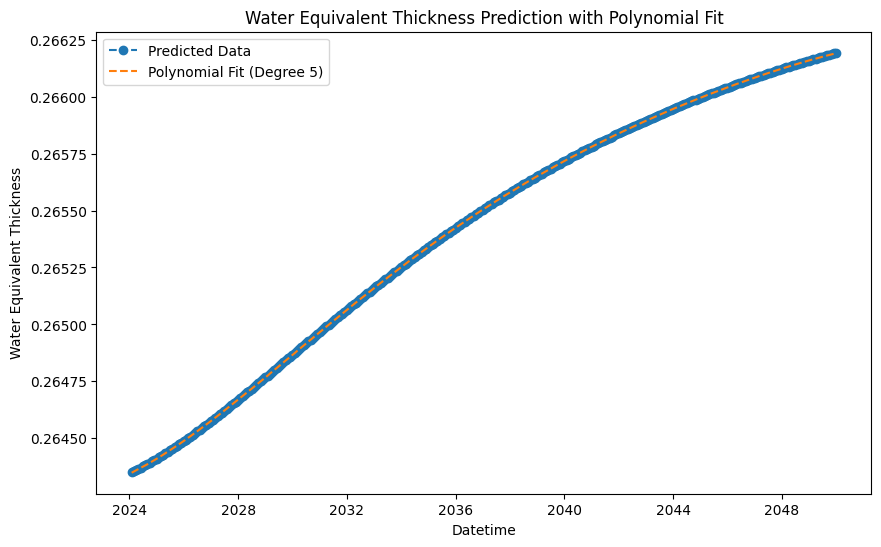

In [101]:
plt.figure(figsize=(10, 6))
plt.plot(future_df['datetime'], future_df['Predicted_WET'], label='Predicted Data', linestyle='dashed', marker='o')
plt.plot(future_df['datetime'], poly_predictions, label=f'Polynomial Fit (Degree {degree})', linestyle='dashed')
plt.xlabel('Datetime')
plt.ylabel('Water Equivalent Thickness')
plt.title('Water Equivalent Thickness Prediction with Polynomial Fit')
plt.legend()
plt.show()